In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')
import json
import numpy as np

# 1. Prepare data

In [35]:
jobs = pd.read_csv("../data/clean_data_train.csv")
jobs = jobs.drop(columns = ['Sex', 'Contract Type'])
jobs_test = pd.read_csv("../data/clean_data_test.csv")
jobs_test = jobs_test.drop(columns = ['Sex', 'Contract Type'])
jobs.head()

,Salary,Level,Year of Experience,Programming Language,Requirement Language,Description Language,Location
0,20500000.0,Nhân viên,2 năm,java,tiếng anh,vi,Hà Nội
1,36500000.0,Nhân viên,2 năm,Khác,tiếng anh,en,Hồ Chí Minh
2,22500000.0,Trưởng/Phó phòng,2 năm,Khác,Không yêu cầu,vi,Hà Nội
3,22500000.0,Trưởng nhóm,3 năm,Khác,Không yêu cầu,vi,Hà Nội
4,30000000.0,Nhân viên,3 năm,php,Không yêu cầu,vi,Hà Nội


In [36]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4973 entries, 0 to 4972
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Salary                4973 non-null   float64
 1   Level                 4973 non-null   object 
 2   Year of Experience    4973 non-null   object 
 3   Programming Language  4973 non-null   object 
 4   Requirement Language  4973 non-null   object 
 5   Description Language  4973 non-null   object 
 6   Location              4973 non-null   object 
dtypes: float64(1), object(6)
memory usage: 272.1+ KB


# 2. Feture engineering

- Duplicate

In [37]:
jobs = jobs.groupby(['Level', 'Year of Experience', 'Programming Language', 'Requirement Language', 
                     'Location', 'Description Language']).mean().reset_index()

## 2.1 Encoding

- StandardScaler for 'Salary'

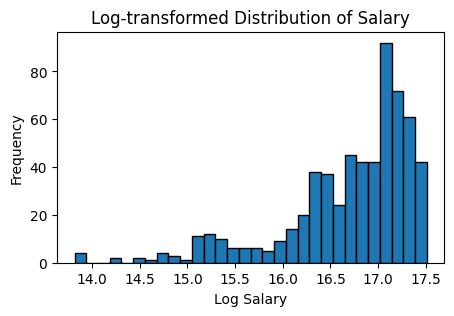

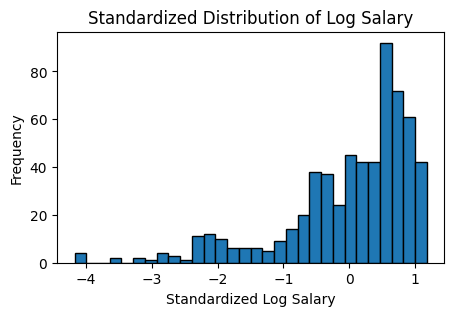

In [38]:
# Giả sử bạn đã có DataFrame jobs với dữ liệu ban đầu
# Áp dụng Log Transformation
jobs['Salary'] = np.log(jobs['Salary'])

# Kiểm tra phân phối sau khi biến đổi Log
plt.figure(figsize=(5, 3))
plt.hist(jobs['Salary'], bins=30, edgecolor='k')
plt.title('Log-transformed Distribution of Salary')
plt.xlabel('Log Salary')
plt.ylabel('Frequency')
plt.show()

# Chuẩn hóa phân phối chuẩn cho biến Salary_log
scaler = StandardScaler()
jobs['Salary'] = scaler.fit_transform(jobs[['Salary']])

# Kiểm tra phân phối sau khi chuẩn hóa
plt.figure(figsize=(5, 3))
plt.hist(jobs['Salary'], bins=30, edgecolor='k')
plt.title('Standardized Distribution of Log Salary')
plt.xlabel('Standardized Log Salary')
plt.ylabel('Frequency')
plt.show()


In [39]:
# Áp dụng Log Transformation cho tập test
jobs_test['Salary'] = np.log(jobs_test['Salary'])

jobs_test['Salary'] = scaler.transform(jobs_test[['Salary']], copy=True)
jobs_test.head()

,Salary,Level,Year of Experience,Programming Language,Requirement Language,Description Language,Location
0,0.597337,Nhân viên,3 năm,Khác,Không yêu cầu,vi,Hà Nội
1,-0.839956,Nhân viên,1 năm,Khác,Không yêu cầu,vi,Hồ Chí Minh
2,-2.582174,Thực tập sinh,Dưới 1 năm,Khác,Không yêu cầu,vi,Hà Nội
3,-0.353061,Nhân viên,1 năm,Khác,tiếng nhật,vi,Hà Nội
4,-0.353061,Nhân viên,1 năm,Khác,tiếng anh,vi,Hà Nội


- Encoding for 'Level'

In [40]:
encoder = OrdinalEncoder(categories=[['Thực tập sinh', 'Nhân viên', 'Trưởng nhóm', 'Trưởng/Phó phòng', 'Quản lý / Giám sát', 'Giám đốc']])
encoded_level = encoder.fit_transform(jobs[['Level']])
jobs['Level'] = encoded_level

In [41]:
jobs_test['Level'] = encoder.transform(jobs_test[['Level']])

- Encoding for 'Lang'

In [42]:
encoder = OrdinalEncoder(categories=[['vi', 'en']])
encoded_l = encoder.fit_transform(jobs[['Description Language']])
jobs['Description Language'] = encoded_l

In [43]:
jobs_test['Description Language'] = encoder.transform(jobs_test[['Description Language']])

- Encoding for 'Year of Experience'

In [44]:
encoder = OrdinalEncoder(categories=[['Không yêu cầu kinh nghiệm', 'Dưới 1 năm', '1 năm', '2 năm', '3 năm', '4 năm', '5 năm', 'Trên 5 năm']])
encoded_YoE = encoder.fit_transform(jobs[['Year of Experience']])
jobs['Year of Experience'] = encoded_YoE

In [45]:
jobs_test['Year of Experience'] = encoder.transform(jobs_test[['Year of Experience']])

- Encoding for 'Programming Language'

In [46]:
encoder = TargetEncoder()
encoded_pl = encoder.fit_transform(jobs['Programming Language'], jobs['Salary'])
jobs['Programming Language'] = encoded_pl

In [47]:
jobs_test['Programming Language'] = encoder.transform(jobs_test[['Programming Language']])

- Encoding for 'Language'

In [48]:
encoder = TargetEncoder()
encoded_l = encoder.fit_transform(jobs['Requirement Language'], jobs['Salary'])
jobs['Requirement Language'] = encoded_pl

In [49]:
jobs_test['Requirement Language'] = encoder.transform(jobs_test[['Requirement Language']])

- Encoding for 'Location'

In [50]:
encoder = TargetEncoder()
encoded_location = encoder.fit_transform(jobs['Location'], jobs['Salary'])
jobs['Location'] = encoded_location

In [51]:
jobs_test['Location'] = encoder.transform(jobs_test[['Location']])

In [52]:
jobs.head()

,Level,Year of Experience,Programming Language,Requirement Language,Location,Description Language,Salary
0,5.0,3.0,-0.060635,-0.060635,-0.262191,0.0,0.865626
1,5.0,4.0,-0.060635,-0.060635,0.146119,0.0,-0.517054
2,5.0,6.0,-0.060635,-0.060635,0.146119,0.0,1.166092
3,5.0,6.0,-0.060635,-0.060635,0.146119,0.0,1.166092
4,1.0,2.0,-0.060635,-0.060635,0.146119,1.0,-0.141857


In [53]:
jobs_test.head()

,Salary,Level,Year of Experience,Programming Language,Requirement Language,Description Language,Location
0,0.597337,1.0,4.0,-0.060635,-0.067255,0.0,0.146119
1,-0.839956,1.0,2.0,-0.060635,-0.067255,0.0,-0.097140
2,-2.582174,0.0,1.0,-0.060635,-0.067255,0.0,0.146119
3,-0.353061,1.0,2.0,-0.060635,0.108132,0.0,0.146119
4,-0.353061,1.0,2.0,-0.060635,0.051509,0.0,0.146119


## 2.2 Correlation with target variable

In [54]:
# Tính toán ma trận tương quan
correlation_matrix = jobs.corr()

# Hiển thị tương quan của từng đặc trưng với biến mục tiêu
target_correlation = correlation_matrix['Salary']
print(target_correlation)

Level                   0.465034
Year of Experience      0.666383
Programming Language    0.136594
Requirement Language    0.136594
Location                0.165582
Description Language    0.007190
Salary                  1.000000
Name: Salary, dtype: float64


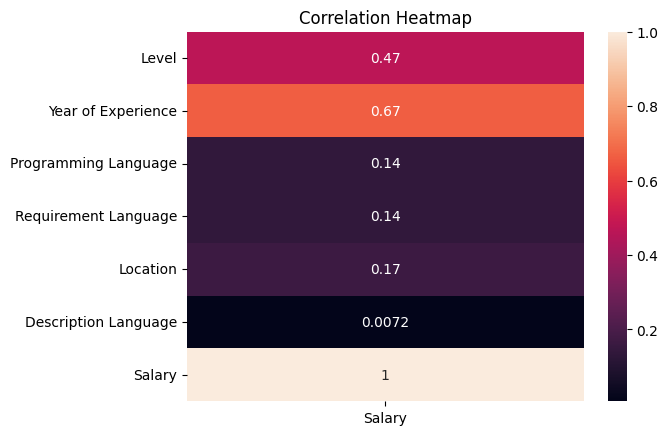

In [55]:
# Tạo DataFrame
correlation_df = pd.DataFrame(target_correlation)

# Assuming you have a correlation matrix called 'correlation_matrix'
sns.heatmap(correlation_df, annot=True)
plt.title('Correlation Heatmap')
plt.show()

# 3. Training

In [56]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'SVR': SVR(),
    'XGB': xgb.XGBRegressor()
}

In [57]:
X = jobs.drop(columns = ['Salary'])
y = jobs['Salary']

- Thử nghiệm các mô hình

                       Model  R2 Score
6                        SVR  0.734783
3  GradientBoostingRegressor  0.730320
4      RandomForestRegressor  0.718229
7                        XGB  0.625946
5      DecisionTreeRegressor  0.617239
1                      Ridge  0.521084
0           LinearRegression  0.520988
2                      Lasso  0.185509
Best performing model: SVR


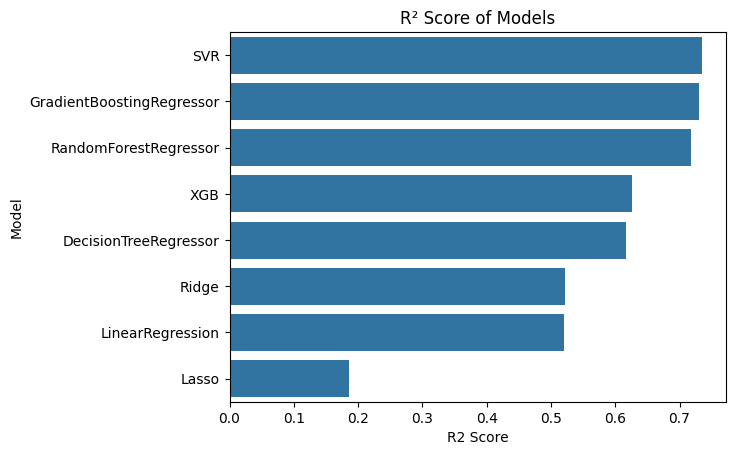

In [58]:
# Khởi tạo KFold để kiểm định chéo
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    # Đánh giá mô hình sử dụng cross-validation và r2 làm thước đo
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    # Tính R² trung bình
    mean_r2 = np.mean(scores)
    results.append((name, mean_r2))

# Sắp xếp kết quả theo R² Score từ cao xuống thấp
results_df = pd.DataFrame(results, columns=['Model', 'R2 Score']).sort_values(by='R2 Score', ascending=False)
print(results_df)

# Lấy tên của mô hình có điểm số R² cao nhất
model_best = results_df['Model'].iloc[0]
print("Best performing model:", model_best)

# Vẽ biểu đồ kết quả
sns.barplot(x='R2 Score', y='Model', data=results_df)
plt.title('R² Score of Models')
plt.show()

- Dùng RFE để lựa chọn bộ đặc trưng tốt nhất

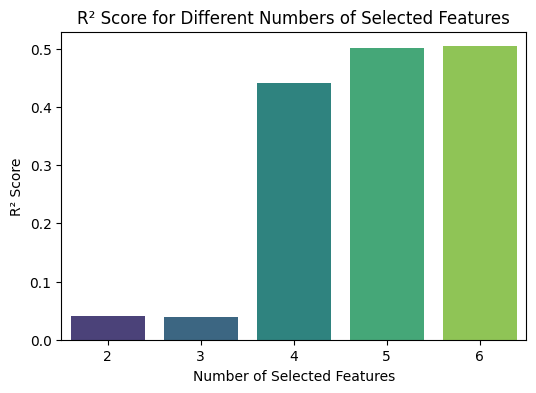

Most important features: ['Level', 'Year of Experience', 'Programming Language', 'Requirement Language', 'Location', 'Description Language']


In [59]:
# Khởi tạo KFold để kiểm định chéo
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
# Định nghĩa mô hình
if model_best == 'SVR':
    model = SVR(kernel='linear')
else :
    model = models['RandomForestRegressor']

# Lặp qua số lượng đặc trưng từ 2 đến số lượng đặc trưng tối đa
for i in range(2, len(X.columns) + 1):
    # Thiết lập RFE với số đặc trưng hiện tại
    selector = RFE(model, n_features_to_select=i, step=1)
    selector.fit(X, y)  # Lưu ý là sử dụng toàn bộ dữ liệu X, y
    
    # Đặc trưng được chọn
    selected_features = X.columns[selector.support_]
    
    # Tạo tập dữ liệu chỉ với các đặc trưng được chọn
    X_selected = selector.transform(X)
    
    # Đánh giá mô hình sử dụng cross-validation
    scores = cross_val_score(model, X_selected, y, cv=kf, scoring='r2')
    
    # Tính R² Score trung bình
    mean_r2 = np.mean(scores)
    
    # Lưu kết quả
    results.append((i, selected_features.tolist(), mean_r2))

# Chuyển kết quả vào DataFrame và sắp xếp theo R²
results_df = pd.DataFrame(results, columns=['Num Features', 'Features', 'R2 Score'])
results_df['R2 Score'] = abs(results_df['R2 Score'])
results_df = results_df.sort_values(by='R2 Score', ascending=False)

# Vẽ biểu đồ barplot
plt.figure(figsize=(6, 4))
sns.barplot(x='Num Features', y='R2 Score', data=results_df, palette='viridis')
plt.title('R² Score for Different Numbers of Selected Features')
plt.xlabel('Number of Selected Features')
plt.ylabel('R² Score')
plt.show()

# Lưu các đặc trưng quan trọng nhất từ mô hình tốt nhất
variable_important = results_df.iloc[0, 1]
print("Most important features:", variable_important)


In [60]:
# Danh sách các mô hình và tham số tương ứng
models = {
    'RandomForestRegressor': (RandomForestRegressor(), {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }),
    'XGBRegressor': (xgb.XGBRegressor(), {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    }),
    'GradientBoostingRegressor': (GradientBoostingRegressor(), {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }),
    'SVR': (SVR(), {
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.5],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    })
}

In [61]:
def find_best_params(variable_important, models, jobs, file_name='best_params.json', KFold=KFold(n_splits=5, shuffle=True, random_state=42)):
    # Phân chia tập dữ liệu
    X = jobs[variable_important]
    y = jobs['Salary']

    # Kết quả lưu tham số tốt nhất
    best_params = {}

    # Đào tạo và điều chỉnh mô hình cho từng loại
    for model_name, (model, params) in models.items():
        print(f"Training {model_name}...")
        
        # Thiết lập Grid Search với kiểm định chéo
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=KFold, scoring='neg_mean_squared_error', verbose=1)
        grid_search.fit(X, y)
        
        # Lưu tham số tốt nhất
        best_params[model_name] = grid_search.best_params_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Ghi kết quả vào file JSON
    with open(file_name, 'w') as fp:
        json.dump(best_params, fp)

    print(f"All best parameters have been saved to {file_name}.")


- Tìm bộ tham số tối ưu

In [62]:
# find_best_params(variable_important, models, jobs)

- Kết quả trên tập train với bộ tham số tối ưu

GradientBoostingRegressor: R2 Score = 0.7592954184787833, RMSE = 0.48889167790872057
RandomForestRegressor: R2 Score = 0.7538942334920004, RMSE = 0.49371855759695704
SVR: R2 Score = 0.7454984034878984, RMSE = 0.5023615484936502
XGBRegressor: R2 Score = 0.745226176553879, RMSE = 0.5018116495698082


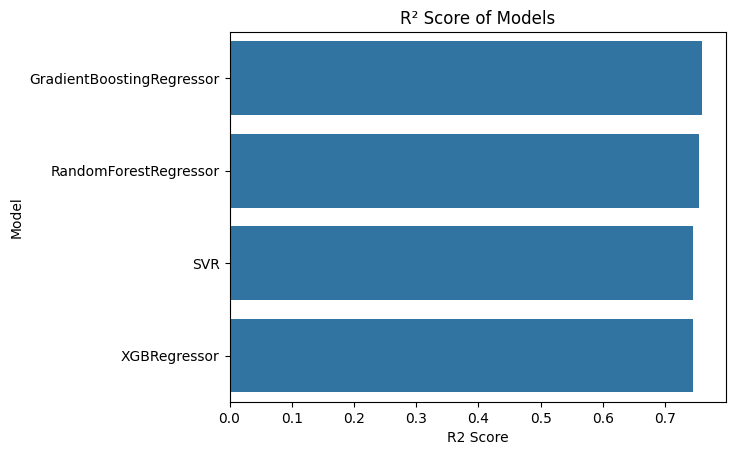

In [63]:
# Đọc file JSON với các tham số tối ưu
with open('best_params.json', 'r') as fp:
    best_params = json.load(fp)

# Tạo dictionary của các mô hình đã cấu hình với random_state và tham số tối ưu
models_configured = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42, **best_params['RandomForestRegressor']),
    'XGBRegressor': xgb.XGBRegressor(random_state=42, **best_params['XGBRegressor']),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42, **best_params['GradientBoostingRegressor']),
    'SVR': SVR( **best_params['SVR'])
}

# Khởi tạo KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Đánh giá mỗi mô hình sử dụng cross-validation và lưu kết quả cho cả R2 và RMSE
results = {}
for name, model in models_configured.items():
    # Tính R2 score
    scores_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mean_r2 = np.mean(scores_r2)
    
    # Tính RMSE (chú ý đến đảo dấu vì kết quả trả về là âm)
    scores_rmse = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    mean_rmse = -np.mean(scores_rmse)  # Đảo dấu để nhận RMSE dương
    
    # Lưu kết quả vào dictionary
    results[name] = {'R2 Score': mean_r2, 'RMSE': mean_rmse}

# Sắp xếp kết quả theo R2 Score giảm dần và in ra
sorted_results = sorted(results.items(), key=lambda x: x[1]['R2 Score'], reverse=True)
for model_name, metrics in sorted_results:
    print(f"{model_name}: R2 Score = {metrics['R2 Score']}, RMSE = {metrics['RMSE']}")

sorted_results_df = pd.DataFrame(sorted_results, columns=['Model', 'Metrics'])
sorted_results_df = pd.concat([sorted_results_df.drop(columns='Metrics'), sorted_results_df['Metrics'].apply(pd.Series)], axis=1)

# Vẽ biểu đồ kết quả
sns.barplot(data=sorted_results_df, x='R2 Score', y='Model')
plt.title('R² Score of Models')
plt.show()

# 4. Testing

RandomForestRegressor: R2 Score = 0.631146113848024, RMSE = 0.5720796908663619
GradientBoostingRegressor: R2 Score = 0.6246894280811859, RMSE = 0.5759377780950495
XGBRegressor: R2 Score = 0.6241108357286099, RMSE = 0.5767473997938456
SVR: R2 Score = 0.6036681374640827, RMSE = 0.591927782128653


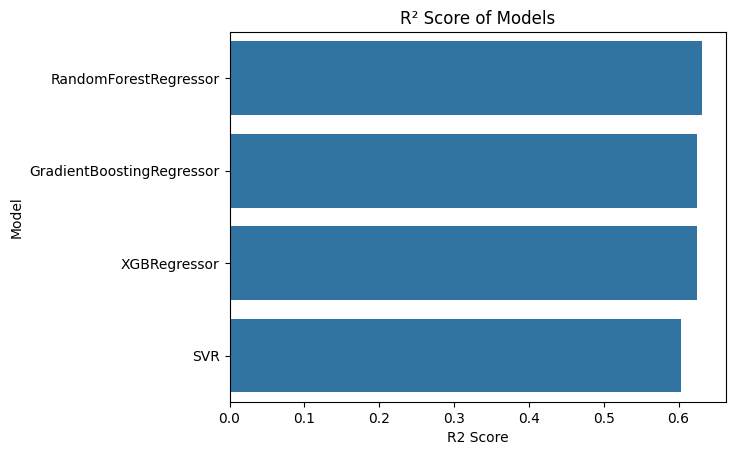

In [64]:
X = jobs_test[variable_important]
y = jobs_test['Salary']

# Đọc file JSON
with open('best_params.json', 'r') as fp:
    best_params = json.load(fp)

# Tạo dictionary của các mô hình đã cấu hình với random_state
models_configured = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42, **best_params['RandomForestRegressor']),
    'XGBRegressor': xgb.XGBRegressor(random_state=42, **best_params['XGBRegressor']),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42, **best_params['GradientBoostingRegressor']),
    'SVR': SVR( **best_params['SVR'])
}

# Khởi tạo KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Đánh giá mỗi mô hình sử dụng cross-validation và lưu kết quả cho cả R2 và RMSE
results = {}
for name, model in models_configured.items():
    # Tính R2 score
    scores_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mean_r2 = np.mean(scores_r2)
    
    # Tính RMSE (chú ý đến đảo dấu vì kết quả trả về là âm)
    scores_rmse = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    mean_rmse = -np.mean(scores_rmse)  # Đảo dấu để nhận RMSE dương
    
    # Lưu kết quả vào dictionary
    results[name] = {'R2 Score': mean_r2, 'RMSE': mean_rmse}

# Sắp xếp kết quả theo R2 Score giảm dần và in ra
sorted_results = sorted(results.items(), key=lambda x: x[1]['R2 Score'], reverse=True)
for model_name, metrics in sorted_results:
    print(f"{model_name}: R2 Score = {metrics['R2 Score']}, RMSE = {metrics['RMSE']}")

sorted_results_df = pd.DataFrame(sorted_results, columns=['Model', 'Metrics'])
sorted_results_df = pd.concat([sorted_results_df.drop(columns='Metrics'), sorted_results_df['Metrics'].apply(pd.Series)], axis=1)

# Vẽ biểu đồ kết quả
sns.barplot(data=sorted_results_df, x='R2 Score', y='Model')
plt.title('R² Score of Models')
plt.show()

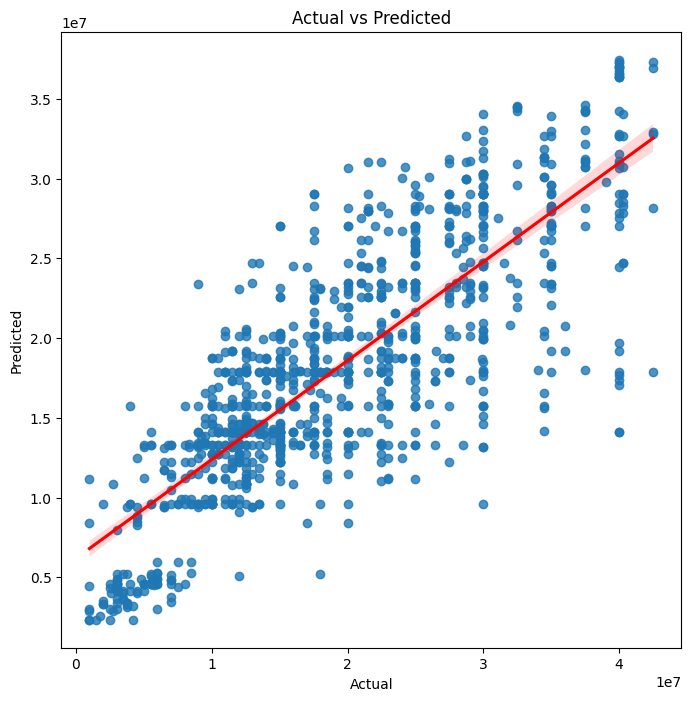

In [65]:
# Vẽ đường hồi quy
model = models_configured['RandomForestRegressor']
model.fit(X, y)
y_pred = model.predict(X)
# Chuyển kết quả về dạng ban đầu
y_original = np.exp(scaler.inverse_transform(pd.DataFrame(y)))
y_pred_original = np.exp(scaler.inverse_transform(pd.DataFrame(y_pred)))

plt.figure(figsize=(8, 8))
sns.regplot(x=y_original, y=y_pred_original, scatter=True, fit_reg=True, line_kws={"color": "red"})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

- Chuyển MRSE về giá trị lương thực

In [66]:
rmse = np.exp(scaler.inverse_transform(pd.DataFrame([-sorted_results_df['RMSE']])))

print(f"RMSE: {rmse}")

RMSE: [[12033601.76344822 12001560.98633846 11994848.04932249 11869673.61161459]]
